# Randomized Benchmarking

## Single-Qubit Clifford Randomized Benchmarking

Randomized benchmarking is a technique used to estimate the average fidelity of quantum gates. The basic idea is to apply a sequence of random gates, followed by an inverse gate that should ideally return the system to its original state. By measuring the fidelity of the final state, one can infer the average error of the gates used in the sequence.m

Performing long sequences of random Clifford gates uniformly sampled from the Clifford group result in an exponential decay of the survival probability. The exponential decay (also called *average sequence fidelity* or *survival rate*) $F$ should be fit to

$$
F(m)= Ap^m + B
$$

where $m$ is the number of Cliffords in the sequence, $A$ and $B$ are parameters related to state preparation and measurement, and $1-p$ is the depolarization rate. Using $p$, the *average gate error per Clifford*, $r_\mathrm{Clifford}$, can be computed as

$$
r_\mathrm{Clifford} = 1-p-\frac{1-p}{d}
$$

where $d=2^N$ is the dimension of the Clifford gates for $N$ qubits. By dividing the Clifford error by the average number of physical gates per Clifford, the **error per gate**, $r_\mathrm{gate}$  can be obtained.

The Clifford Randomized Benchmarking protocol can be summarized as follows:
1. Initialize the qubit in the ground state.
2. Apply a sequence of $m$ Cliffords to the qubit.
3. Apply an additional $(m+1)$ gate which inverts the whole sequence.
4. Measure the resulting ground state probability.
5. Repeat this procedure $k$ times.
6. Repeat for multiple lengths $m$ to build up an exponential decay.

### Setup a single-qubit device

In [1]:
from chalmers_qubit.sarimner import SarimnerProcessor, SarimnerModel, SarimnerCompiler, DecoherenceNoise

transmon_dict = {
    0: {"frequency": 5.02, "anharmonicity": -0.3},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
}

# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict)
compiler = SarimnerCompiler(model=model)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

### Loop over sequences

We now create the single-qubit Clifford group. The Clifford gate decomposition follows Ref. [Epstein et al. Phys. Rev. A 89, 062321 (2014)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.89.062321)

In [2]:
from qutip import basis, fidelity
from chalmers_qubit.utils.randomized_benchmarking import RandomizedBenchmarking

sequences = [8, 64, 128, 256, 512, 1024]
sequence_fidelity = []

rb = RandomizedBenchmarking(clifford_group=1)

# Loop over sequence lengths
for m in sequences:
    print(f"Running sequence length {m}")
    
    # Generate the randomized benchmarking circuit
    clifford_qc = rb.randomized_benchmarking_circuit(
        number_of_cliffords=m,
        apply_inverse=True,
    )
    
    # Simulate the quantum circuit and compute the probability of remaning in the initial state
    init_state = basis(3,0)

    result = sarimner.run_state(
        init_state=init_state, 
        qc=clifford_qc
    )

    final_state = result.states[-1]

    # Compute the survival probability
    sequence_fidelity.append(fidelity(init_state, final_state))

Running sequence length 8
Running sequence length 64


/Users/vikstal/miniconda3/envs/chalmers-qubit/lib/python3.10/site-packages/qutip-5.1.1-py3.10-macosx-11.1-arm64.egg/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Running sequence length 128
Running sequence length 256
Running sequence length 512
Running sequence length 1024


### Fit the data to an exponential decay

We fit the exponential decay (also called *average sequence fidelity* or *survival rate*) $F$ to

$$
F(m)= Ap^m + B
$$

A = 0.2924810870421409, p = 0.9990258411302686, B = 0.7090256673869222


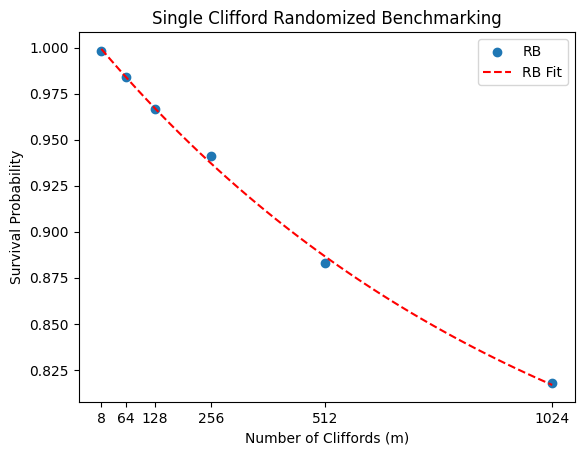

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the model function
def model(m, A, p, B) -> float:
    return A * p**m + B

# Initial guess for A, p, B
initial_guess = [1, 0.99, 0.5]

# Fit the curve
params, covariance = curve_fit(model, sequences, sequence_fidelity, p0=initial_guess)

# Extract fitted parameters
A_fit, p_fit, B_fit = params
print(f"A = {A_fit}, p = {p_fit}, B = {B_fit}")

# Plot
x_fit = np.linspace(min(sequences), max(sequences), 100)
y_fit = model(x_fit, A_fit, p_fit, B_fit)

plt.scatter(sequences, sequence_fidelity, label="RB")
plt.plot(x_fit, y_fit, label="RB Fit", color='red', linestyle='--')
plt.legend()
plt.xlabel("Number of Cliffords (m)")
plt.ylabel("Survival Probability")
plt.title("Single Clifford Randomized Benchmarking")
plt.xticks(sequences)
plt.show()

Calculate the average error per clifford and average error per gate. The average error per gate is calculated by dividing the average error per clifford by the average number of physical gates per clifford. The average number of physical gates per clifford is calculated by taking the average number of gates in the decomposition of the clifford group.

In [4]:
r_clifford = 1 - p_fit - (1-p_fit) / 2
print(f"Error per Clifford: {(r_clifford):.2e}")
print(f"Error per Gate: {(r_clifford / 1.875):.2e}")

Error per Clifford: 4.87e-04
Error per Gate: 2.60e-04


## Two-Qubit Interleaved Randomized Benchmarking

The interleaved Clifford randomized benchmarking (RB) gate error provides an estimate for the average error of a target Clifford gate in a gate set.

Clifford RB provides the average gate error over all of the gates in the gate set used to decompose the Clifford gates. In contrast, interleaved Clifford RB characterizes the average error of a specific Clifford gate, which is interleaved through the random Clifford sequences used in RB. If the RB random Clifford gate sequence is expressed as:

$$
C_1C_2\ldots C_m C_\mathrm{inverse},
$$

where each $C$ is a Clifford gate, then the interleaved RB sequence can be written as:

$$
C_1C_\mathrm{target}C_2C_\mathrm{target}\ldots C_mC_\mathrm{target}C'_\mathrm{inverse}
$$

where $C_\mathrm{target}$ is the gate to characterize and must also be part of the Clifford group. Additionally, the final inverting gate must be updated to invert the full gate sequence including $C_\mathrm{target}$. The specific gate error is obtained by comparing the decay parameters in $F(m)$ for both the non-interleaved and interleaved RB results.

The fitted decay parameters from the non-interleaved RB and the interleaved RB are denoted by $p$ (or $p_\mathrm{reference}$ in some sources) and $p_\mathrm{interleaved}$ respectively. Then, the interleaved RB gate error for $C_\mathrm{target}$ is found using

$$
r_{C_\mathrm{target}}=\frac{(d-1)(1-\frac{p_\mathrm{interleaved}}{p})}{d}
$$

### Setup a two-qubit device

In [5]:
transmon_dict = {
    0: {"frequency": 5.02, "anharmonicity": -0.3},
    1: {"frequency": 4.82, "anharmonicity": -0.3},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
    1: {"t1": 60e3, "t2": 100e3},
}

# The time for the CZ-gate that we want in (ns)
t = 100

# Corresponding coupling in (GHz)
g = 1 / (np.sqrt(2) * 2 * t)

coupling_dict = {
    (0, 1): g,
}

# Set up the model, compiler, and processor
model = SarimnerModel(transmon_dict=transmon_dict, coupling_dict=coupling_dict)
compiler = SarimnerCompiler(model=model)
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

In [6]:
from qutip import tensor, basis, fidelity
from qutip_qip.operations import CZ
from chalmers_qubit.utils.randomized_benchmarking import RandomizedBenchmarking

rb = RandomizedBenchmarking(clifford_group=2)
def run_rb_sequence(m, interleaved_gate=None):
    """Run a single RB sequence and return the survival probability."""
    print(f"Running sequence length {m}" + (" (interleaved)" if interleaved_gate else ""))
    
    # Generate the circuit
    circuit = rb.randomized_benchmarking_circuit(
        number_of_cliffords=m,
        apply_inverse=True,
        interleaved_clifford_gate=interleaved_gate
    )
    
    # Simulate and compute fidelity
    init_state = tensor([basis(3, 0), basis(3, 0)])
    result = sarimner.run_state(init_state=init_state, qc=circuit)
    final_state = result.states[-1]
    
    return fidelity(init_state, final_state)

# Setup
sequences = [8, 64, 128, 256]
interleaved_gate = CZ(controls=0, targets=1)

# Run experiments
sequence_fidelity = []
sequence_fidelity_interleaved = []

for m in sequences:
    # Standard RB
    sequence_fidelity.append(
        run_rb_sequence(m)
    )
    
    # Interleaved RB
    sequence_fidelity_interleaved.append(
        run_rb_sequence(m, interleaved_gate)
    )


Running sequence length 8
Running sequence length 8 (interleaved)
Running sequence length 64
Running sequence length 64 (interleaved)
Running sequence length 128
Running sequence length 128 (interleaved)
Running sequence length 256
Running sequence length 256 (interleaved)


### Fit the data to an exponential decay

A = 0.490037470583182, p = 0.9929824343043575, B = 0.5068321923876039
A (int) = 0.49337557282076605, p (int) = 0.9902325668934058, B (int) = 0.5128888624137452


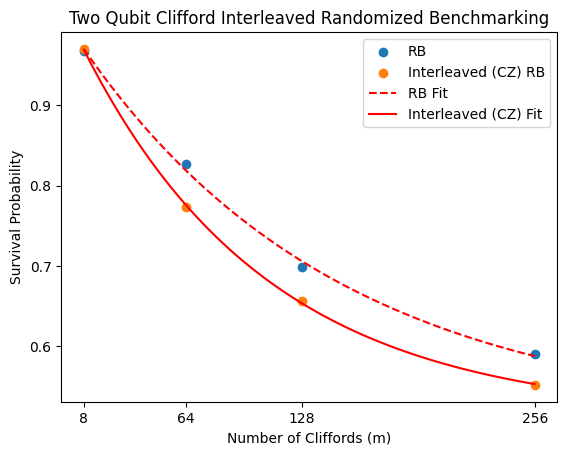

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the model function
def model(m, A, p, B) -> float:
    return A * p**m + B

# Initial guess for A, p, B
initial_guess = [1, 0.99, 0.5]

# Fit the curve
params, covariance = curve_fit(model, sequences, sequence_fidelity, p0=initial_guess)

# Fit the curve
params_interleaved, covariance_interleaved = curve_fit(model, sequences, sequence_fidelity_interleaved, p0=initial_guess)

# Extract fitted parameters
A_fit, p_fit, B_fit = params
print(f"A = {A_fit}, p = {p_fit}, B = {B_fit}")

A_interleaved_fit, p_interleaved_fit, B_interleaved_fit = params_interleaved
print(f"A (int) = {A_interleaved_fit}, p (int) = {p_interleaved_fit}, B (int) = {B_interleaved_fit}")

# Plot
x_fit = np.linspace(min(sequences), max(sequences), 100)
y_fit = model(x_fit, A_fit, p_fit, B_fit)

y_interleaved_fit = model(x_fit, A_interleaved_fit, p_interleaved_fit, B_interleaved_fit)

plt.scatter(sequences, sequence_fidelity, label="RB")
plt.scatter(sequences, sequence_fidelity_interleaved, label="Interleaved (CZ) RB")
plt.plot(x_fit, y_fit, label="RB Fit", color='red', linestyle='--')
plt.plot(x_fit, y_interleaved_fit, label="Interleaved (CZ) Fit", color='red')
plt.legend()
plt.xlabel("Number of Cliffords (m)")
plt.ylabel("Survival Probability")
plt.title("Two Qubit Clifford Interleaved Randomized Benchmarking")
plt.xticks(sequences)
plt.show()


In [8]:
# Calculate average error per CZ gate
d = 4
r_cz = (d - 1)/d * (1 - p_interleaved_fit/p_fit)
print(f"Average error per CZ gate: {(r_cz):.2e}")

Average error per CZ gate: 2.08e-03
